# Throughput prediction from historical values for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

##  Select your link

In [8]:
sS='UC'
srcSiteThroughputServer = "192.170.227.162"

dS='IU'
destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteThroughputServer = "72.36.96.9"

### Get the data from Elasticsearch

In [9]:
my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'term': {'_type': 'throughput'}},
                        {'range': {'timestamp': {'gte': '2016-08-10', 'lt': '2016-08-30'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    }
}

scroll = list(scan(client=es, query=my_query))


In [10]:
site = {srcSiteThroughputServer: sS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
for res in scroll:
    count += 1
    dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S')
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
    data[s].set_value( ts, 'timestamp', dt)
#     if count<2: print(res, ts)
print(count)

533


In [11]:
#data[sS]
data[sS].sort_index(inplace=True) 
data[dS].sort_index(inplace=True) 
print(type(data[sS]))
print( data[sS].head() )
print( data[dS].head() )

<class 'pandas.core.frame.DataFrame'>
              throughput           timestamp
1.470873e+12    3.286156 2016-08-10 23:46:17
1.470877e+12    4.011438 2016-08-11 00:53:38
1.470879e+12    4.610140 2016-08-11 01:34:33
1.470883e+12    3.729643 2016-08-11 02:32:55
1.470888e+12    4.812338 2016-08-11 04:05:11
              throughput           timestamp
1.470876e+12    6.889903 2016-08-11 00:33:38
1.470881e+12    2.716201 2016-08-11 01:57:31
1.470883e+12    6.730338 2016-08-11 02:33:32
1.470889e+12    4.477283 2016-08-11 04:23:02
1.470897e+12    2.991792 2016-08-11 06:23:42


In [12]:
sTS=data[sS].ix[:,0]
#sTS

## Standard error of estimate for three different regressions

### ordinary mean

In [13]:
sOM=sTS-sTS.mean()
sOM=sOM.rename('simple_mean_residual')
res = pd.concat([sTS, sOM], axis=1)
sOM.describe() 

count    2.610000e+02
mean     1.420745e-15
std      1.645362e+00
min     -2.908549e+00
25%     -1.241218e+00
50%     -2.968834e-01
75%      1.224695e+00
max      4.649843e+00
Name: simple_mean_residual, dtype: float64

### rolling window mean

In [14]:
sRM=sTS.rolling(window=5).mean()
sRMr=sTS-sRM
sRMr=sRMr.rename('rolling_mean_residual')
res = pd.concat([res, sRMr], axis=1)
sRMr.describe()

count    257.000000
mean       0.006797
std        1.131198
min       -2.925672
25%       -0.811738
50%       -0.001251
75%        0.726621
max        2.947637
Name: rolling_mean_residual, dtype: float64

### EWMA

In [15]:
sEWMA=sTS.ewm(halflife=3).mean()
sEWMAr=sTS-sEWMA
sEWMAr=sEWMAr.rename('EWMA_residual')
res = pd.concat([res, sEWMAr], axis=1)
sEWMAr.describe()

count    261.000000
mean       0.015093
std        1.063217
min       -2.523165
25%       -0.758431
50%       -0.030741
75%        0.695499
max        2.944881
Name: EWMA_residual, dtype: float64

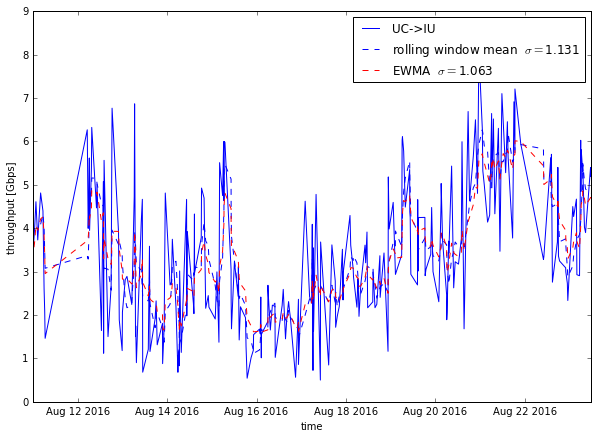

In [20]:
plt.figure(figsize=[10, 7])
# sTS.plot(ls='-', label=sS+'->'+dS)
ts=data[sS].ix[:,1]
plt.plot(ts, sTS, ls='-', label=sS+'->'+dS)
plt.plot(ts, sRM, ls='--', c='b', label='rolling window mean  ' + '$\sigma=$' + "{:.3f}".format(sRMr.std()))
plt.plot(ts, sEWMA, ls='--', c='r', label='EWMA  ' + '$\sigma=$' + "{:.3f}".format(sEWMAr.std()))

plt.legend()
plt.xlabel('time')
plt.ylabel('throughput [Gbps]')
plt.ylim(ymin=0)
plt.savefig('Plots/ThroughputPredictionForLink_' + sS +'_to_'+ dS + '.png',dpi=150)
plt.show()

### check for periodicity

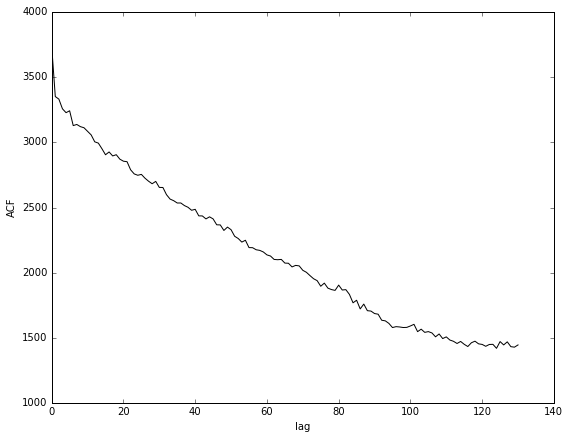

In [21]:
acs = np.correlate(sTS, sTS, mode='same')
# print(acs)
acs=acs[int(acs.size/2):]
plt.figure(figsize=[9, 7])
plt.plot(acs,'k-')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.savefig('Plots/ThroughputAutocorrelationForLink_' + sS +'_to_'+ dS + '.png',dpi=150)
plt.show()